<a href="https://colab.research.google.com/github/hitesha14/Rising2021_Timeseries/blob/main/Copy_of_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
df = pd.read_csv(r'https://api.covid19india.org/csv/latest/case_time_series.csv')

In [ ]:
df.head()

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January 2020,2020-01-30,1,1,0,0,0,0
1,31 January 2020,2020-01-31,0,1,0,0,0,0
2,1 February 2020,2020-02-01,0,1,0,0,0,0
3,2 February 2020,2020-02-02,1,2,0,0,0,0
4,3 February 2020,2020-02-03,1,3,0,0,0,0


In [ ]:
df.describe()

,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
count,478.000000,4.780000e+02,478.000000,4.780000e+02,478.000000,478.000000
mean,54995.529289,6.294503e+06,48249.930962,5.657688e+06,617.089958,87415.654812
std,87250.607082,6.199014e+06,77991.369440,5.565253e+06,895.591405,75238.905902
min,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,7371.250000,1.673925e+05,3812.250000,7.382975e+04,100.000000,4777.250000
50%,23662.000000,5.858972e+06,20573.000000,4.799650e+06,342.000000,92279.500000
75%,61675.500000,1.063689e+07,58095.750000,1.029560e+07,775.000000,152591.750000
max,414280.000000,2.628786e+07,422391.000000,2.306347e+07,4529.000000,294969.000000


In [ ]:
df.drop_duplicates(subset=['Date_YMD'], keep=False,inplace=True)

In [ ]:
validate = df['Daily Confirmed'].tail(10)
df.drop(df['Daily Confirmed'].tail(10).index,inplace=True)

In [ ]:
uni_data = df['Daily Confirmed']
df['Date_YMD'] =  pd.to_datetime(df['Date_YMD'])
uni_data.index = df['Date_YMD']
uni_data.head()

Date_YMD
2020-01-30    1
2020-01-31    0
2020-02-01    0
2020-02-02    1
2020-02-03    1
Name: Daily Confirmed, dtype: int64

In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 48
horizon = 10
TRAIN_SPLIT = 400
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[2.41382640e-06]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.41382640e-06]
 [2.41382640e-06]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.82765280e-06]
 [2.41382640e-06]
 [5.31041807e-05]
 [4.82765280e-06]
 [2.41382640e-06]
 [7.24147919e-06]
 [1.20691320e-05]
 [2.17244376e-05]
 [3.62073960e-05]
 [1.93106112e-05]
 [2.41382640e-05]
 [2.41382640e-05]
 [2.65520904e-05]
 [2.41382640e-05]
 [3.37935696e-05]
 [4.82765280e-05]]

 Target horizon
[[6.03456599e-05]
 [6.51733127e-05]
 [1.40001931e-04]
 [1.88278459e-04]
 [1.66554021e-04

In [ ]:
BATCH_SIZE = 20
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')


In [ ]:
model_path = r'\Chapter 6\GRU_Univarient_1.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 8s 54ms/step - loss: 0.0030 - val_loss: 0.0665
Epoch 2/150
100/100 [==============================] - 5s 48ms/step - loss: 5.6620e-04 - val_loss: 0.0405
Epoch 3/150
100/100 [==============================] - 5s 48ms/step - loss: 4.5887e-04 - val_loss: 0.0352
Epoch 4/150
100/100 [==============================] - 5s 48ms/step - loss: 3.6261e-04 - val_loss: 0.0202
Epoch 5/150
100/100 [==============================] - 5s 50ms/step - loss: 3.6961e-04 - val_loss: 0.0324
Epoch 6/150
100/100 [==============================] - 5s 48ms/step - loss: 3.3089e-04 - val_loss: 0.0252
Epoch 7/150
100/100 [==============================] - 5s 48ms/step - loss: 2.8611e-04 - val_loss: 0.0166
Epoch 8/150
100/100 [==============================] - 5s 48ms/step - loss: 2.8932e-04 - val_loss: 0.0301
Epoch 9/150
100/100 [==============================] - 5s 49ms/step - loss: 2.5577e-04 - val_loss: 0.0125
Epoch 10/150
100/100 [============================

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [ ]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 48, 100)           30900     
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 54,210
Trainable params: 54,210
Non-trainable params: 0
_________________________________________________________________


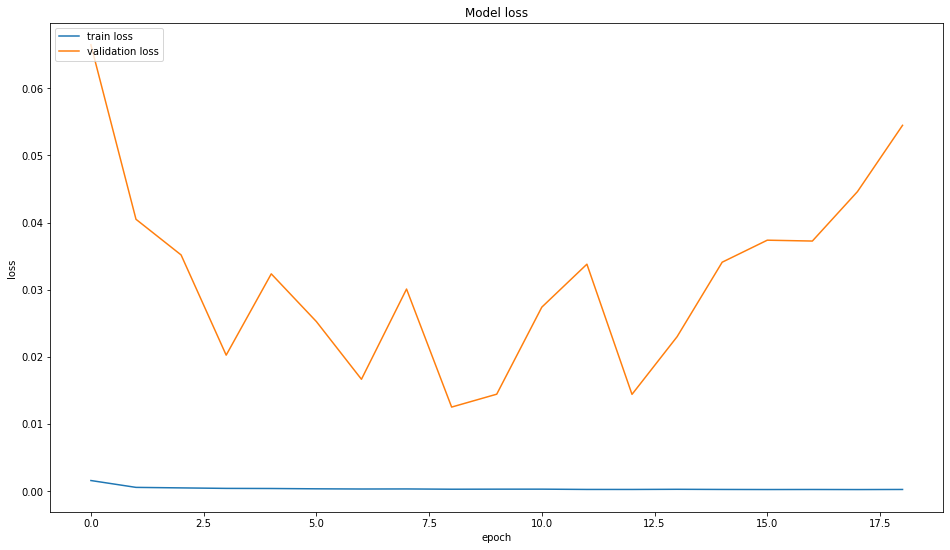

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['Daily Confirmed']
validatehori = uni.tail(48)

In [ ]:
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

In [ ]:
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))

In [ ]:
Predicted_results = Trained_model.predict(val_rescaled)

In [ ]:
Predicted_results

array([[0.7460373 , 0.68408716, 0.65702283, 0.6183448 , 0.5633169 ,
        0.5381933 , 0.5162927 , 0.5138012 , 0.502023  , 0.45124468]],
      dtype=float32)

In [ ]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)

In [ ]:
Predicted_inver_res

array([[322588.56, 300221.88, 290450.5 , 276486.06, 256618.62, 247547.92,
        239640.88, 238741.34, 234488.89, 216155.73]], dtype=float32)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res[0])

Evaluation metric results:-
MSE is : 1123594045.5417724
MAE is : 32454.7609375
RMSE is : 33520.05437856228
MAPE is : 10.977719236326797
R2 is : 0.14380216778246147



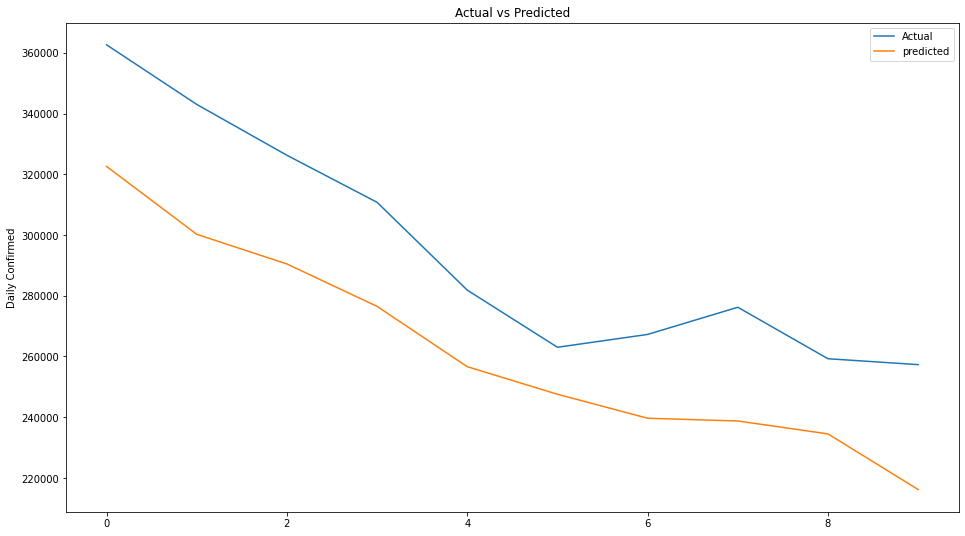

In [ ]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Daily Confirmed")
plt.legend(('Actual','predicted'))
plt.show()